## Feature selection and engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2_contingency
from sklearn.model_selection import RandomizedSearchCV

sns.set_style("darkgrid")

In [ ]:
data = pd.read_csv('../data/processed/modelling.csv')

Based on the findings we have found, it doesn't seem like any of the training variables have a very strong relationship with the target variable (Time duration between doctor to departure). It's not expected a highly accurate model could be generated from the data.

Let's first select features that are relevant to the model we're trying to build.


The fields "Arrival Date" and "Dr Seen Date" are very closely related. They are very closely correlated with the only difference in the dates being the minutes captured in "TimeDiff Arrival-TreatDrNr (mins)". As such, having both fields would add redundant data to the model. 

In [45]:
data = data.drop(["Dr Seen Date"], axis = 1)

In [46]:
data.head()

,Triage Priority,Age (yrs),Arrival Date,Depart Actual Date,Departure Status Desc.,Depart. Dest. Code,TimeDiff Arrival-Actual Depart (mins),TimeDiff TreatDrNr-Act. Depart (mins),Presenting Complaint Desc.,Diagnosis Desc.,TimeDiff Arrival-TreatDrNr (mins),log(TimeDiff TreatDrNr-Act. Depart (mins)),Season,Day of Week,log(TimeDiff Arrival-TreatDrNr (mins))
0,3,15,2009-01-01 00:17:00,2009-01-01 12:30:00,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,733,619.0,DRUG / ALCOHOL / POISONING,EMOTIONAL CRISIS,114.0,6.429719,Summer,3,4.744932
2,4,8,2009-01-01 00:55:00,2009-01-01 01:08:00,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,13,0.0,EYE,CONJUNCTIVITIS,13.0,0.000000,Summer,3,2.639057
3,3,12,2009-01-01 03:22:00,2009-01-01 05:00:00,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,98,26.0,PAIN,OTITIS EXTERNA,72.0,3.295837,Summer,3,4.290459
4,4,15,2009-01-01 03:55:00,2009-01-01 08:29:00,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,274,119.0,INJURY,KNEE SPRAIN / STRAIN,155.0,4.787492,Summer,3,5.049856
5,4,2,2009-01-01 06:40:00,2009-01-01 08:29:00,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,109,9.0,INJURY,LACERATED FACE,100.0,2.302585,Summer,3,4.615121


- Features that are generated after a doctor sees a patient cannot be used in the model. For the model to be implemented in real time by the hospital after a doctor sees a patient, any data reflecting the departure of the customer will not be available
- these features can't be included to traing the model


In [47]:
training_vars = ['Triage Priority', ' Age  (yrs)', 'Arrival Date', 'Presenting Complaint Desc.', 'Diagnosis Desc.', 'log(TimeDiff Arrival-TreatDrNr (mins))']
test_var = ['log(TimeDiff TreatDrNr-Act. Depart (mins))']

In [48]:
training_df = data[training_vars]
test_df = data[test_var]

In [49]:
training_df

,Triage Priority,Age (yrs),Arrival Date,Presenting Complaint Desc.,Diagnosis Desc.,log(TimeDiff Arrival-TreatDrNr (mins))
0,3,15,2009-01-01 00:17:00,DRUG / ALCOHOL / POISONING,EMOTIONAL CRISIS,4.744932
2,4,8,2009-01-01 00:55:00,EYE,CONJUNCTIVITIS,2.639057
3,3,12,2009-01-01 03:22:00,PAIN,OTITIS EXTERNA,4.290459
4,4,15,2009-01-01 03:55:00,INJURY,KNEE SPRAIN / STRAIN,5.049856
5,4,2,2009-01-01 06:40:00,INJURY,LACERATED FACE,4.615121
...,...,...,...,...,...,...
30183,4,8,2010-12-30 21:11:00,FEVER,TONSILLITIS,3.970292
30184,3,0,2010-12-30 21:16:00,PAIN,VIRAL INFECTION,5.459586
30185,3,0,2010-12-30 22:28:00,COUGH,CROUP,4.983607
30186,3,6,2010-12-30 23:26:00,RESPIRATORY,PERTUSSIS,4.077537


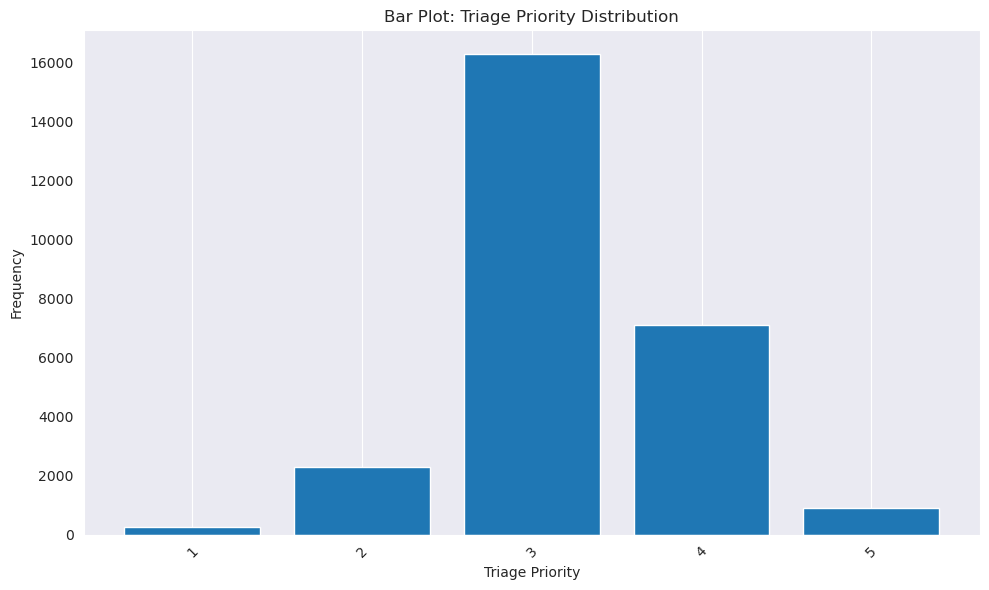

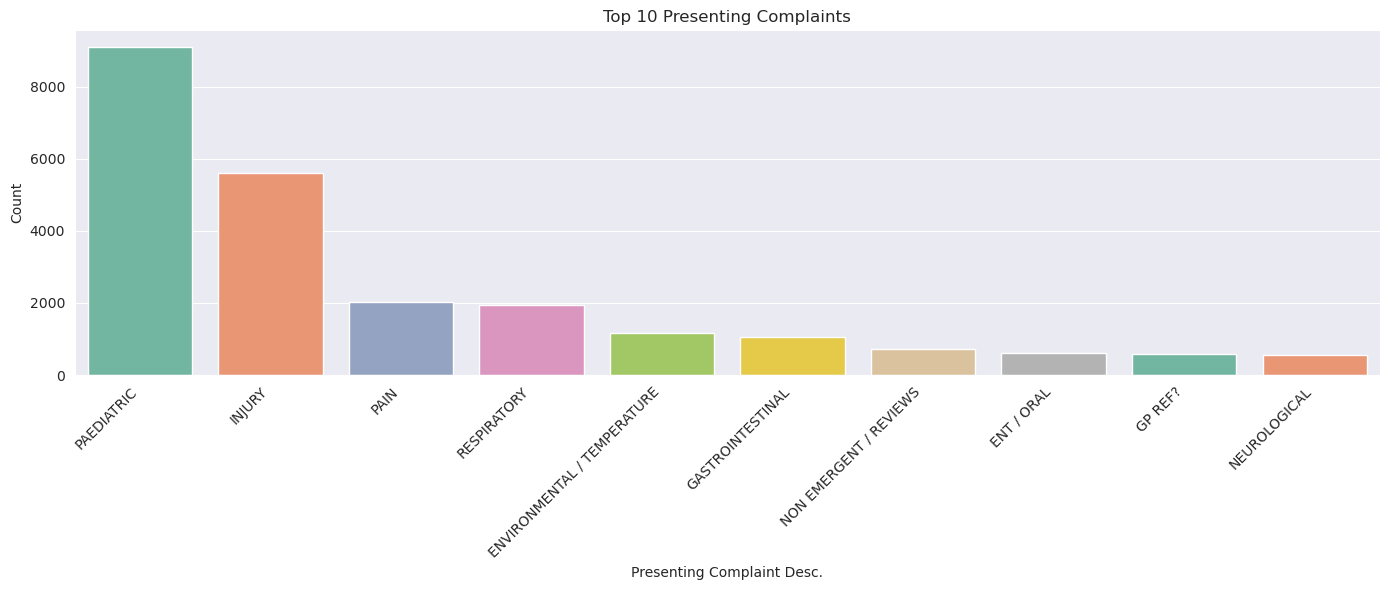

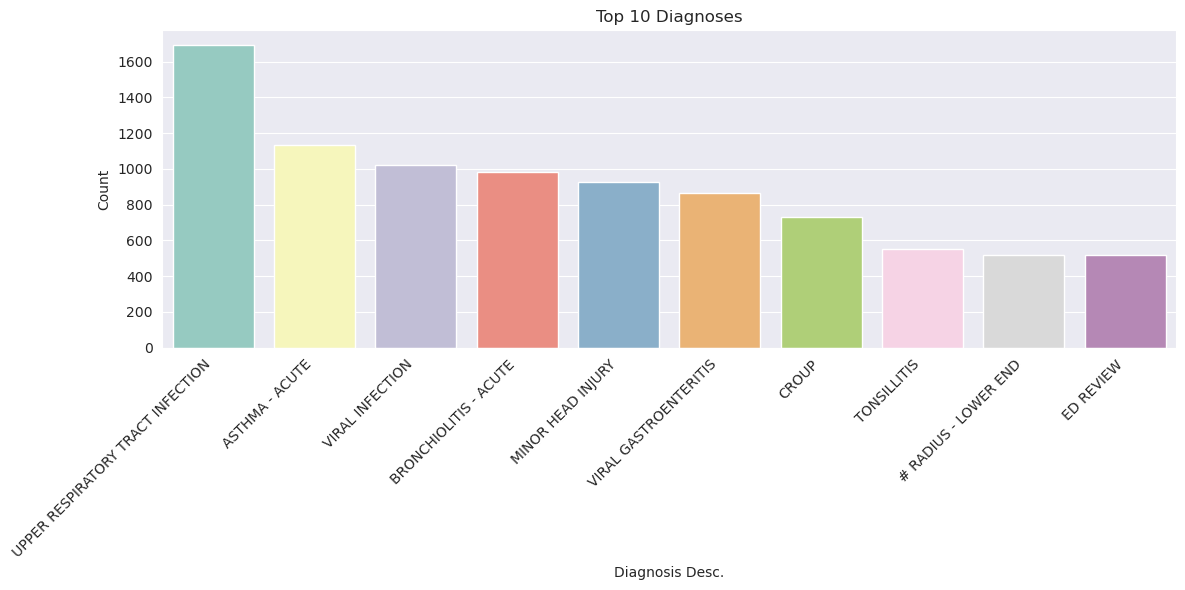

In [50]:
categorical = ["Triage Priority", "Presenting Complaint Desc.", "Diagnosis Desc."]
top_n = 10

# Plot count distribution for 'Triage Priority'
plt.figure(figsize=(10, 6))
plt.bar(triage_priority_counts.index, triage_priority_counts.values)
plt.xlabel('Triage Priority')
plt.ylabel('Frequency')
plt.title('Bar Plot: Triage Priority Distribution')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
# Plot count distribution for 'Presenting Complaint Desc.'
plt.figure(figsize=(14, 6))
sns.countplot(x='Presenting Complaint Desc.', data=data, palette='Set2', order=data['Presenting Complaint Desc.'].value_counts().nlargest(top_n).index)
plt.xlabel('Presenting Complaint Desc.')
plt.ylabel('Count')
plt.title(f'Top {top_n} Presenting Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot count distribution for 'Diagnosis Desc.'
plt.figure(figsize=(12, 6))
sns.countplot(x='Diagnosis Desc.', data=data, palette='Set3', order=data['Diagnosis Desc.'].value_counts().nlargest(top_n).index)
plt.xlabel('Diagnosis Desc.')
plt.ylabel('Count')
plt.title(f'Top {top_n} Diagnoses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Due to the training features consisting of many categorical variables, encoding these variables using label and one hto encoding inevitably leads to high dimensionality in the dataset. This creates problem in feature selection process. Models such as gradient boosting or random forest are great at handling high dimensional data for feature importance.

In addition, as we saw during our data exploration, none of numerical independent variables had an obvious linear correlation with the target variable. Implementing models like linear regression would only capture linear relationships in the model, which aren't too apparent within this data. On the otherhand, models like Random Forest and Gradient Boosting Regression are great at handling non linear relationships and high dimensionality, which is applicable to the training data at hand.

## Feature encoding: converting categorical data and non-numerical data to numerical features

In [51]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
training_df_copy = training_df.copy()

# Extract month, day of the week, and hour from 'Arrival Date' using .dt
training_df_copy['Arrival_Month'] = training_df_copy['Arrival Date'].dt.month
training_df_copy['Arrival_Dayofweek'] = training_df_copy['Arrival Date'].dt.dayofweek
training_df_copy['Arrival_Hour'] = training_df_copy['Arrival Date'].dt.hour

# Drop the 'Arrival Date' column from the copied DataFrame
training_df_copy.drop(columns=['Arrival Date'], inplace=True)

training_df = training_df_copy


In [52]:
# Categorical data encoding
# Perform One-Hot Encoding for nominal categorical variables
nominal_cols = ['Presenting Complaint Desc.', 'Diagnosis Desc.']
training_df = pd.get_dummies(training_df, columns=nominal_cols, drop_first=True)

# Perform Label Encoding for ordinal categorical variable 'Triage Priority'
label_encoder = LabelEncoder()
training_df['Triage Priority'] = label_encoder.fit_transform(training_df['Triage Priority'])

In [53]:
# Drop the target variable from the DataFrame to get the features for training
X = training_df

# Get the target variable for training
y = test_df

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize the models
rf_model = RandomForestRegressor(random_state=1)
gb_model = GradientBoostingRegressor(random_state=1)
lr_model = LinearRegression()

In [54]:
# Train the models
rf_model.fit(X_train, y_train.values.ravel())
gb_model.fit(X_train, y_train.values.ravel())
lr_model.fit(X_train, y_train.values.ravel())

# Predict on the test set
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)


In [55]:
# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

# Print the results
print("Random Forest Regression:")
print("Mean Squared Error:", rf_mse)
print("R-squared:", rf_r2)
print("---------------------")
print("Gradient Boosting Regression:")
print("Mean Squared Error:", gb_mse)
print("R-squared:", gb_r2)
print("---------------------")
print("Linear Regression:")
print("Mean Squared Error:", lr_mse)
print("R-squared:", lr_r2)

Random Forest Regression:
Mean Squared Error: 1.0253373431942634
R-squared: 0.19860425951835226
---------------------
Gradient Boosting Regression:
Mean Squared Error: 0.9906659145638892
R-squared: 0.22570318008846846
---------------------
Linear Regression:
Mean Squared Error: 3.4894019394446054e+17
R-squared: -2.727289579044908e+17


Random Forest and Gradient Boosting Regression are performing far better than Linear Regression as expected. As little to no linear relationships were apparent during our analysis, and due to high dimensionality, linear regression is not the ideal model for this task

Based on the lower Mean squared error value and higher R-squared value, at baseline, the Gradient Boosting Regression is performing best. The performance is still no means very high. Let's try seeing which features were most relevant

In [ ]:
feature_importances = gb_model.feature_importances_

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_10_features = importance_df.head(10)
bottom_10_features = importance_df.tail(10)

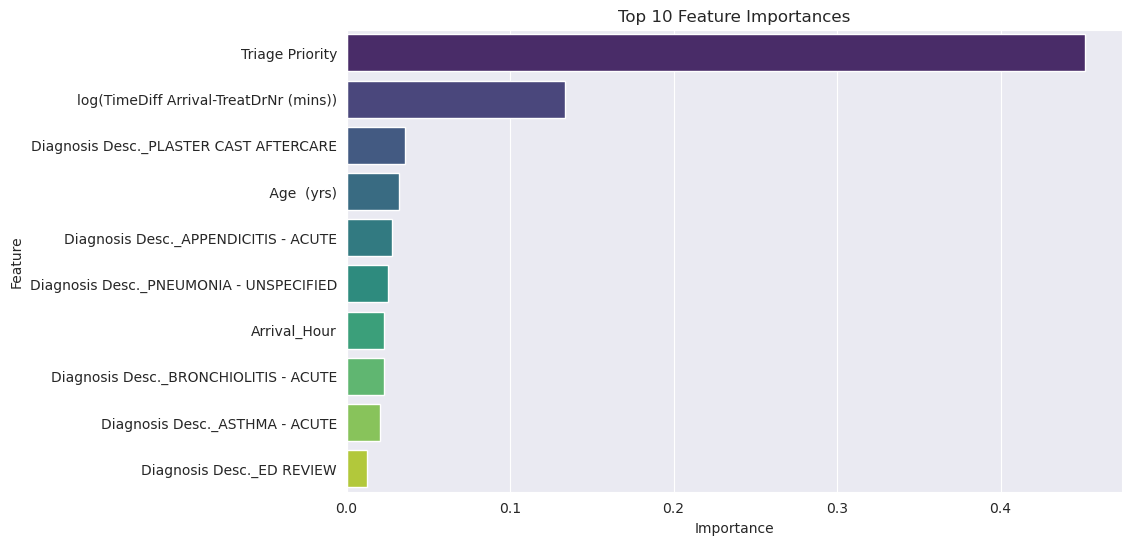

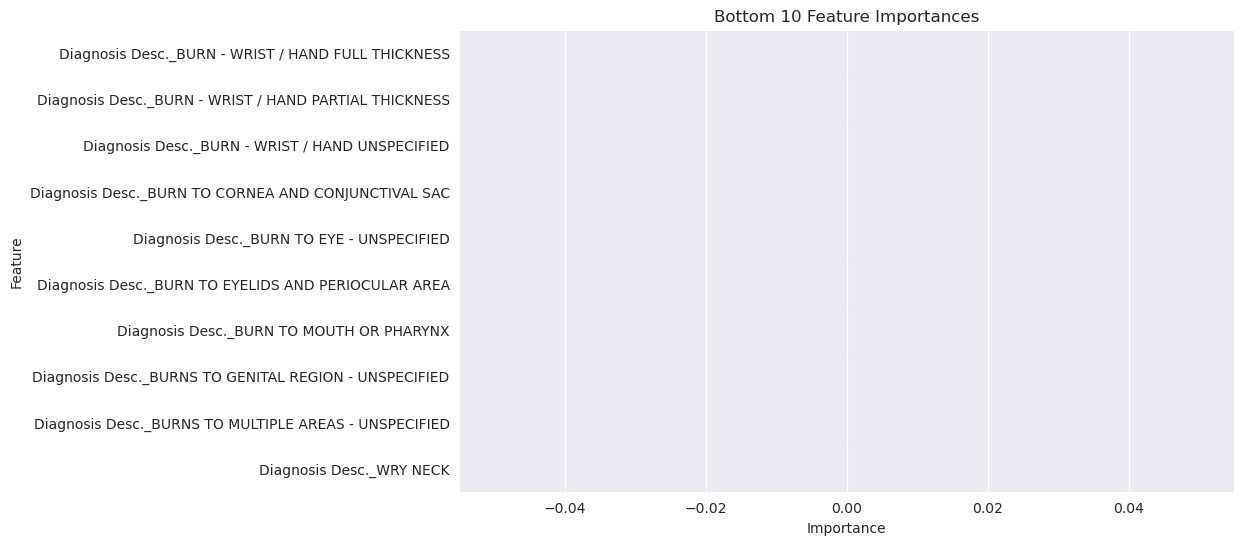

In [54]:
# Create the bar plots for top 10 and bottom 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=bottom_10_features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Bottom 10 Feature Importances')
plt.show()

- Triage Priority is by far the most important to predict the time duration spent after seeing a doctor 
- The time spent from arrival to seeing a doctor had the second most impact
- All the other features didn't have a high impact

As a gradient boost inherent utilises feature importance to handle high dimensional data, feature selection is not necessary. Let's move to tuning the hyper parameters

In [59]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train.values.ravel())

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
gb_predictions = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, gb_predictions)
r2 = r2_score(y_test, gb_predictions)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error: 0.9727475925191598
R-squared: 0.23970800207075327


Based on these results, the model performed reasonably well. The MSE score being slightly less than 1 indicates that, on average, the model's predictions of the transformed target variable are approximately off by 1 unit from the actual values. The R-squared score of 0.24 suggests that the model explains about 24% of the variance in the data, which is a modest level of explanation.

It is important to note that the target variable was log-transformed, which affects the scale of the values. Therefore, any predictions made by the model in real-time must be reverse-transformed to obtain the actual values.

Considering the data the model was trained with, the results are in line with expectations. Variance in the target variable is expected due to various factors such as the number of doctors working at a given time, differences in patient characteristics, the varying severity of the same diagnosis, and other unaccounted factors. Some variables may not be captured in the data, and this can impact the target variable.

Overall, the model shows promise in capturing patterns and relationships within the data, but there are likely additional factors influencing the target variable that are not accounted for in the model. Further improvements could be made by incorporating more relevant features or exploring different modeling techniques.